                            Challenge 2: Anticipating Household Displacement in Communities

Comparing differences in demographics among families experiencing high rent burden (vs not) organized by census tracts in LA County/surrounding areas

Data Sources: (all referenced from the US census.gov website)

- American Community Survey 2022 (5 year estimates) for Housing Costs (AKA B25070)
- American Community Survey 2022 (5 year estimates) for Demographic Data (AKA DP05)

[Further discussion on GH]()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

In [2]:
data = pd.read_csv(r'C:\Users\wisery\Data Science Projects\DataKind\Census Data\American Community Survey\Housing Costs B25070\5 Year Estimates\ACSDT5Y2022.B25070-Data.csv')
demographic_data_raw = pd.read_csv(r'C:\Users\wisery\Data Science Projects\DataKind\Census Data\American Community Survey\Demographics DP05\ACSDP5Y2022.DP05-Data.csv', low_memory=False)

### Data Manipulation

In [3]:
# limiting data to include only LA County and Orange County (based on Country FIPS codes 037 and 059, respectively)
#geodata_CA = geodata_CA.loc[(geodata_CA['COUNTYFP'].str.contains('037'))|
#                            (geodata_CA['COUNTYFP'].str.contains('059'))]

In [4]:
# dropping margin of error columns from housing costs data set
data = data.drop(columns= ['B25070_001M', 'B25070_002M', 'B25070_003M', 'B25070_004M', 'B25070_005M', 'B25070_006M', 'B25070_007M', 'B25070_008M', 'B25070_009M', 'B25070_010M', 'B25070_011M', 'Unnamed: 24'], axis = 1)

In [5]:
# keeping the percentage-based demographic columns (getting rid of margin of error data, total counts)
drop_these = []
for column in demographic_data_raw.columns:
    if (not column.endswith('PE')) and (column not in ['GEO_ID', 'NAME']) or (column.endswith('M')):
        drop_these.append(column)

In [6]:
demographic_data = demographic_data_raw.drop(columns=drop_these, axis=1)

In [7]:
# There are 4 columns with duplicated column names in this dataset. This removes them
demographic_data = demographic_data.loc[:, ~demographic_data.columns.duplicated()]

In [8]:
#demographic_data.info()

In [9]:
#demographic_data['Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race)']
#drop_these.append('Percent!!Total housing units')

In [10]:
# Changing headers
data.columns = data.iloc[0,:]
data = data.iloc[1:,:]

demographic_data.columns = demographic_data.iloc[0,:]
demographic_data = demographic_data.iloc[1:,:]

In [11]:
# There are 98 census tracts in this data set that do not have survey responses, so I will remove those from my calculations

data = data.loc[data['Estimate!!Total:'] != '0']

In [12]:
# "Burdened" here means spending more than 30% of the household income on rent
# Census tracts with 0 survey replies will be "calculated" as having "Insufficient survey results"

def calculate_burdened_households (row):
    over_30 = (row[8:12].astype('float')).sum()
    percentage_over_30 = over_30 / float(row.iloc[2]) if float(row.iloc[2]) != 0 else "Insufficient survey results"
    under_30 = (row[3:8].astype('float')).sum()
    percentage_under_30 = under_30 / float(row.iloc[2]) if float(row.iloc[2]) != 0 else "Insufficient survey results"
    return percentage_over_30, percentage_under_30

In [13]:
results = data[['Geography', 'Geographic Area Name']]
#results

In [14]:
results['proportion_cost_burdened'],_ = zip(*data.apply(calculate_burdened_households, axis = 1))

results

C:\Users\wisery\AppData\Local\Temp\ipykernel_146192\3691446260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['proportion_cost_burdened'],_ = zip(*data.apply(calculate_burdened_households, axis = 1))


,Geography,Geographic Area Name,proportion_cost_burdened
1,1400000US06001400100,Census Tract 4001; Alameda County; California,0.062992
2,1400000US06001400200,Census Tract 4002; Alameda County; California,0.108808
3,1400000US06001400300,Census Tract 4003; Alameda County; California,0.374335
4,1400000US06001400400,Census Tract 4004; Alameda County; California,0.228861
5,1400000US06001400500,Census Tract 4005; Alameda County; California,0.457859
...,...,...,...
9125,1400000US06115040902,Census Tract 409.02; Yuba County; California,0.505219
9126,1400000US06115041001,Census Tract 410.01; Yuba County; California,0.403125
9127,1400000US06115041002,Census Tract 410.02; Yuba County; California,0.205128
9128,1400000US06115041101,Census Tract 411.01; Yuba County; California,0.586957


In [15]:
# merging demographic & housing cost data sets
merged_data = results.merge(demographic_data, how= 'inner', on=['Geography', 'Geographic Area Name'])
merged_data

,Geography,Geographic Area Name,proportion_cost_burdened,Percent!!SEX AND AGE!!Total population,Percent!!SEX AND AGE!!Total population!!Male,Percent!!SEX AND AGE!!Total population!!Female,Percent!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females),Percent!!SEX AND AGE!!Total population!!Under 5 years,Percent!!SEX AND AGE!!Total population!!5 to 9 years,Percent!!SEX AND AGE!!Total population!!10 to 14 years,...,Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Asian alone,Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone,Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Some Other Race alone,Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Two or More Races,Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Two or More Races!!Two races including Some Other Race,"Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Two or More Races!!Two races excluding Some Other Race, and three or more races",Percent!!Total housing units,"Percent!!CITIZEN, VOTING AGE POPULATION!!Citizen, 18 and over population","Percent!!CITIZEN, VOTING AGE POPULATION!!Citizen, 18 and over population!!Male","Percent!!CITIZEN, VOTING AGE POPULATION!!Citizen, 18 and over population!!Female"
0,1400000US06001400100,Census Tract 4001; Alameda County; California,0.062992,3269,49.6,50.4,(X),4.1,7.3,6.9,...,14.6,0.0,0.8,5.3,0.5,4.8,(X),2351,47.4,52.6
1,1400000US06001400200,Census Tract 4002; Alameda County; California,0.108808,2147,50.1,49.9,(X),7.9,2.0,3.7,...,11.7,0.0,0.4,8.5,0.0,8.5,(X),1679,49.4,50.6
2,1400000US06001400300,Census Tract 4003; Alameda County; California,0.374335,5619,49.8,50.2,(X),2.3,7.1,4.2,...,11.3,0.0,1.1,9.1,1.2,7.8,(X),4414,47.6,52.4
3,1400000US06001400400,Census Tract 4004; Alameda County; California,0.228861,4278,45.0,55.0,(X),7.5,7.1,6.1,...,8.7,0.0,0.2,7.7,1.7,6.1,(X),3180,46.9,53.1
4,1400000US06001400500,Census Tract 4005; Alameda County; California,0.457859,3949,47.4,52.6,(X),4.0,4.1,3.2,...,9.4,0.2,0.0,8.3,0.7,7.6,(X),3169,44.3,55.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9026,1400000US06115040902,Census Tract 409.02; Yuba County; California,0.505219,1868,60.4,39.6,(X),12.3,6.7,3.7,...,4.4,0.5,0.0,4.0,0.0,4.0,(X),1398,65.2,34.8
9027,1400000US06115041001,Census Tract 410.01; Yuba County; California,0.403125,3672,52.9,47.1,(X),6.9,3.6,2.8,...,0.0,0.0,0.0,4.9,1.8,3.1,(X),2904,53.8,46.2
9028,1400000US06115041002,Census Tract 410.02; Yuba County; California,0.205128,3417,49.1,50.9,(X),2.6,3.6,7.0,...,0.8,0.3,0.0,11.4,7.3,4.1,(X),2852,48.9,51.1
9029,1400000US06115041101,Census Tract 411.01; Yuba County; California,0.586957,2288,50.3,49.7,(X),2.7,10.2,6.1,...,0.0,0.0,0.0,4.9,0.0,4.9,(X),1667,53.4,46.6


In [16]:
# Manually removing columns that only contain (X) or - as values
merged_data = merged_data.drop(columns= [
    'Percent!!Total housing units', 
    'Percent!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females)', 
    'Percent!!SEX AND AGE!!Total population!!Median age (years)', 
    'Percent!!SEX AND AGE!!Total population!!18 years and over!!Sex ratio (males per 100 females)', 
    'Percent!!SEX AND AGE!!Total population!!65 years and over!!Sex ratio (males per 100 females)', 'Percent!!SEX AND AGE!!Total population!!65 years and over!!Male', 'Percent!!SEX AND AGE!!Total population!!65 years and over!!Female'], axis= 1)

### ML to identify features correlated with high rent burden

In [17]:
# specifying target & features

targets = merged_data['proportion_cost_burdened']
features = merged_data.iloc[:,3:]

In [18]:
x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=0.25, random_state=1234)

In [19]:
# Initialize the model (Random Forest Regressor)

rf_model = RandomForestRegressor(n_estimators=100, random_state=1234)


In [20]:
#for column in merged_data.columns:
#    if '-' in str(merged_data.loc[1:,column]):
#        print(f"Column: {column}")

In [21]:
#problem_columns = []
#for column in merged_data.columns:
#    try: 
#        float(str(merged_data.loc[:, column]))
#    except ValueError:
#        problem_columns.append(column)
#print(problem_columns)

['Geography', 'Geographic Area Name', 'proportion_cost_burdened', 'Percent!!SEX AND AGE!!Total population', 'Percent!!SEX AND AGE!!Total population!!Male', 'Percent!!SEX AND AGE!!Total population!!Female', 'Percent!!SEX AND AGE!!Total population!!Under 5 years', 'Percent!!SEX AND AGE!!Total population!!5 to 9 years', 'Percent!!SEX AND AGE!!Total population!!10 to 14 years', 'Percent!!SEX AND AGE!!Total population!!15 to 19 years', 'Percent!!SEX AND AGE!!Total population!!20 to 24 years', 'Percent!!SEX AND AGE!!Total population!!25 to 34 years', 'Percent!!SEX AND AGE!!Total population!!35 to 44 years', 'Percent!!SEX AND AGE!!Total population!!45 to 54 years', 'Percent!!SEX AND AGE!!Total population!!55 to 59 years', 'Percent!!SEX AND AGE!!Total population!!60 to 64 years', 'Percent!!SEX AND AGE!!Total population!!65 to 74 years', 'Percent!!SEX AND AGE!!Total population!!75 to 84 years', 'Percent!!SEX AND AGE!!Total population!!85 years and over', 'Percent!!SEX AND AGE!!Total population!

In [22]:
merged_data.loc[1000, problem_columns]

0
Geography                                                                                                                                                                                 1400000US06023000500
Geographic Area Name                                                                                                                                               Census Tract 5; Humboldt County; California
proportion_cost_burdened                                                                                                                                                                              0.503297
Percent!!SEX AND AGE!!Total population                                                                                                                                                                    3473
Percent!!SEX AND AGE!!Total population!!Male                                                                                                                              

In [23]:
x_train.describe(include= 'all')

,Percent!!SEX AND AGE!!Total population,Percent!!SEX AND AGE!!Total population!!Male,Percent!!SEX AND AGE!!Total population!!Female,Percent!!SEX AND AGE!!Total population!!Under 5 years,Percent!!SEX AND AGE!!Total population!!5 to 9 years,Percent!!SEX AND AGE!!Total population!!10 to 14 years,Percent!!SEX AND AGE!!Total population!!15 to 19 years,Percent!!SEX AND AGE!!Total population!!20 to 24 years,Percent!!SEX AND AGE!!Total population!!25 to 34 years,Percent!!SEX AND AGE!!Total population!!35 to 44 years,...,Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!American Indian and Alaska Native alone,Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Asian alone,Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Native Hawaiian and Other Pacific Islander alone,Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Some Other Race alone,Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Two or More Races,Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Two or More Races!!Two races including Some Other Race,"Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Not Hispanic or Latino!!Two or More Races!!Two races excluding Some Other Race, and three or more races","Percent!!CITIZEN, VOTING AGE POPULATION!!Citizen, 18 and over population","Percent!!CITIZEN, VOTING AGE POPULATION!!Citizen, 18 and over population!!Male","Percent!!CITIZEN, VOTING AGE POPULATION!!Citizen, 18 and over population!!Female"
count,6773,6773,6773,6773,6773,6773,6773,6773,6773,6773,...,6773,6773,6773,6773,6773,6773,6773,6773,6773,6773
unique,4096,320,320,172,168,178,209,266,416,285,...,83,696,97,85,170,81,160,3381,366,366
top,4222,50.4,49.6,5.4,5.0,6.0,6.1,4.7,15.1,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2576,49.8,50.2
freq,8,84,84,113,115,106,114,119,63,91,...,4499,291,4987,3789,430,3410,502,8,76,76


In [24]:
# Train the model on the training data
rf_model.fit(x_train, y_train)

RandomForestRegressor(random_state=1234)

In [25]:
y_pred = rf_model.predict(x_test)

In [26]:
# Evaluate the model with mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.02252553949073591


In [29]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

R-squared: 0.10824928188104854


In [32]:
n = x_test.shape[0]  # number of samples
p = x_test.shape[1]  # number of features

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R-squared: {adjusted_r2}')

Adjusted R-squared: 0.07377755600806557


C:\Users\wisery\AppData\Local\Temp\ipykernel_146192\3893928383.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


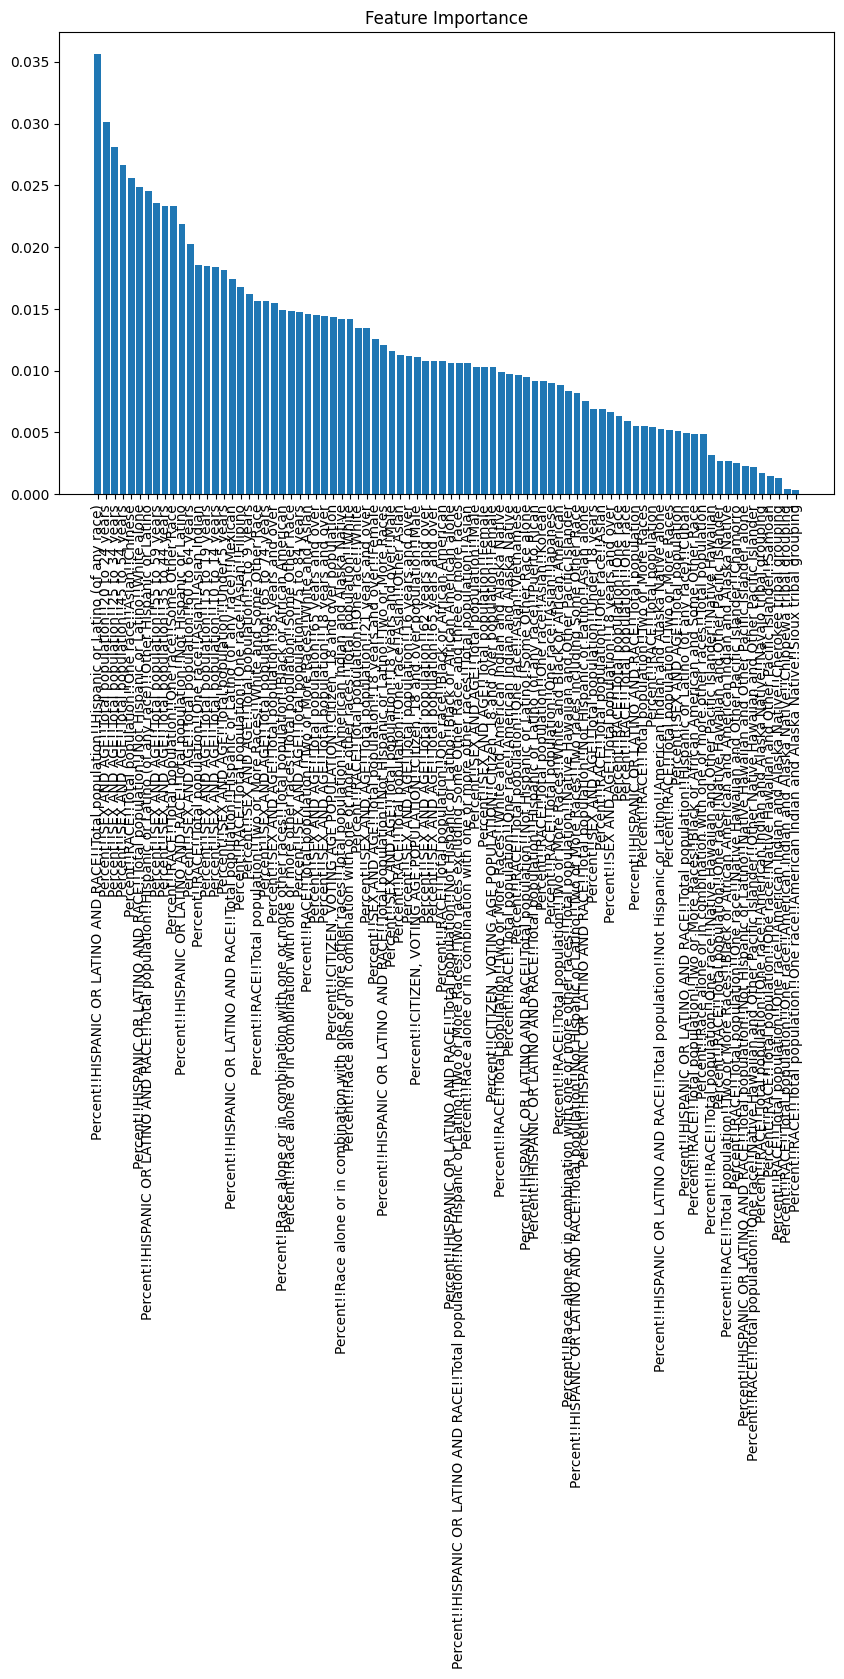

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance scores
feature_importances = rf_model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Get the names of the features
feature_names = features.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(features.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(features.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [38]:
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index=features.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
0,
Percent!!HISPANIC OR LATINO AND RACE!!Total population!!Hispanic or Latino (of any race),0.035617
Percent!!SEX AND AGE!!Total population!!20 to 24 years,0.030140
Percent!!SEX AND AGE!!Total population!!25 to 34 years,0.028098
Percent!!SEX AND AGE!!Total population!!45 to 54 years,0.026653
Percent!!RACE!!Total population!!One race!!Asian!!Chinese,0.025566
...,...
Percent!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Navajo tribal grouping,0.001725
Percent!!RACE!!Total population!!One race!!Native Hawaiian and Other Pacific Islander!!Samoan,0.001459
Percent!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Cherokee tribal grouping,0.001337
